# Entrenamiento Completo - CSTR (CTRL + ORCH)

**Pipeline completo**:
1. **Fase 1**: Entrenar agente CTRL para controlar Tc y F del CSTR
2. **Fase 2**: Entrenar agente ORCH para optimizar Cb usando el CTRL entrenado

---

## 1. Imports y Setup

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Agregar path del proyecto si es necesario
sys.path.append('../../')

from Environment.Simulation_Env.Reactor_CSTR import CSTRSimulator
from Environment.PIDControlEnv_simple import PIDControlEnv_Simple
from Environment.PIDControlEnv_complex import PIDControlEnv_Complex
from Agente.DQN.train_DQN import DQNTrainer
from Agente.DDPG.train_DDPG import DDPGTrainer
from Aux.Plots import SimplePlotter, print_summary

print(" Imports completados")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponible: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

 Imports completados
PyTorch version: 2.2.2
Device disponible: CPU


---
# FASE 1: Entrenar Agente CTRL

**Objetivo**: Entrenar un agente que ajuste parámetros PID para controlar Tc y F.

**Variables**:
- **Manipulables**: Tc (290-450 K), F (99-105 m³/s)
- **Setpoints**: Valores aleatorios dentro de los rangos
- **Agente**: Aprende a ajustar (Kp, Ki, Kd) para cada variable

## 2. Configuración CTRL

In [6]:
config_ctrl = {
    # ============ AMBIENTE ============
    'env_config': {
        'architecture': 'simple',
        'env_type': 'simulation',
        'max_time_detector': 30,
        'action_type': 'continuous',

        # 2 variables manipulables (Tc, F)
        'n_manipulable_vars': 2,
        'manipulable_ranges': [
            (300, 420),   # T del reactor [K]
            (99.5, 104),    # V del reactor [m³]
        ],

        # Los setpoints se generan aleatoriamente
        'manipulable_setpoints': None,  # Random

        'dt_usuario': 1.0,
        'max_steps': 100,

        'agent_controller_config': {
            'agent_type': 'continuous'
        },

        # Simulador CSTR
        'env_type_config': {
            'dt': 1.0,
            'control_limits': ((290, 450), (99.5, 104))
        },

        # Pesos de recompensa
        'reward_weights': {
            'error': 1.0,
            'tiempo': 0.001,
            'overshoot': 0.3,
            'energy': 0.001
        },
        'reward_dead_band': 0.02,

        # Límites PID
        'pid_limits': [
            (0.01, 50.0),
            (0.001, 1.0),
            (0.0, 1.0)
        ],
        'delta_percent_ctrl': 0.2,
    },

    # ============ AGENTE CTRL ============
    'agent_ctrl_config': {
        'algorithm': 'ddpg',
        'state_dim': 10,       # 2 vars × 5 features
        'action_dim': 6,       # 2 vars × 3 params (Kp, Ki, Kd)
        'n_vars': 2,
        'action_type': 'continuous',
        'hidden_dims': (128, 64),
        'lr_actor': 0.0001,
        'lr_critic': 0.001,
        'gamma': 0.99,
        'tau': 0.005,
        'noise_sigma': 0.2,
        'noise_theta': 0.15,
        'batch_size': 64,
        'warmup_steps': 500,
        'buffer_size': 50000,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'seed': 42
    },

    # ============ ENTRENAMIENTO ============
    'n_episodes': 30,
    'max_steps_per_episode': 500,
    'eval_frequency': 50,
    'save_frequency': 9999,
    'log_frequency': 10,
    'checkpoint_dir': 'checkpoints/cstr_ctrl',
}

print("Configuración CTRL creada")
print(f"  Episodios: {config_ctrl['n_episodes']}")
print(f"  Device: {config_ctrl['agent_ctrl_config']['device']}")

Configuración CTRL creada
  Episodios: 30
  Device: cpu


## 3. Test Ambiente Simple

In [7]:
# Test ambiente
test_env = PIDControlEnv_Simple(config_ctrl['env_config'])
sim_cfg = config_ctrl['env_config']['env_type_config']
simulator = CSTRSimulator(**sim_cfg)
test_env.proceso.connect_external_process(simulator)
print('CSTR conectado al ambiente simple')

# Reset y step de prueba
obs, info = test_env.reset()
print(f"\nObservación shape: {obs.shape}")
print(f"  PVs iniciales: {test_env.manipulable_pvs}")
print(f"  Setpoints: {test_env.manipulable_setpoints}")

# Step aleatorio
action = test_env.action_space.sample()
obs, reward, done, truncated, info = test_env.step(action)
print(f"\nStep de prueba exitoso")
print(f"  Reward: {reward:.2f}")

CSTR conectado al ambiente simple

Observación shape: (10,)
  PVs iniciales: [327.0, 102.0]
  Setpoints: [315.69393205595026, 103.93080165342204]

Step de prueba exitoso
  Reward: -47.23


## 4. Entrenar CTRL

In [8]:
# Crear trainer CTRL
trainer_ctrl = DDPGTrainer(config_ctrl)

# Conectar CSTR
sim_cfg = config_ctrl['env_config']['env_type_config']
simulator = CSTRSimulator(**sim_cfg)
trainer_ctrl.env.proceso.connect_external_process(simulator)
print('CSTR conectado al trainer CTRL')

print("\nEntrenando agente CTRL...\n")
print(trainer_ctrl.env.proceso.external_process)
print(trainer_ctrl.env.response_time_detectors.proceso.external_process)
trainer_ctrl.train()
print("\nEntrenamiento CTRL completado")

DDPG Agent creado | role=ctrl | state=10 | action=6 | n_vars=2 | device=cpu
CSTR conectado al trainer CTRL

Entrenando agente CTRL...


Episodio 0/30
  Reward: -1732.28 | Length: 101
  Actor Loss: 0.0000 | Critic Loss: 0.0000

Episodio 10/30
  Reward: -876.92 | Length: 101
  Actor Loss: 56.0875 | Critic Loss: 70.6607

Episodio 20/30
  Reward: -2463.19 | Length: 101
  Actor Loss: 109.1349 | Critic Loss: 263.0660

Entrenamiento CTRL completado


## 5. Visualizar Resultados CTRL

In [22]:
import importlib
import Aux.Plots  # o el path que uses para importarlo

importlib.reload(Aux.Plots)

# Volver a instanciar
from Aux.Plots import SimplePlotter, print_summary
plotter = SimplePlotter()


RESULTADOS CTRL
RESUMEN DE ENTRENAMIENTO

Métrica                        Último       Promedio     Mejor       
Reward                            -1448.91    -1324.60     -217.75
Energy                         71578179.15 69952784.21 50689300.15
Max Overshoot (%)                     0.00        0.00        0.00

 Mejor episodio: #9 (Reward: -217.75)
Mejora total: 16.4%
Total episodios: 30


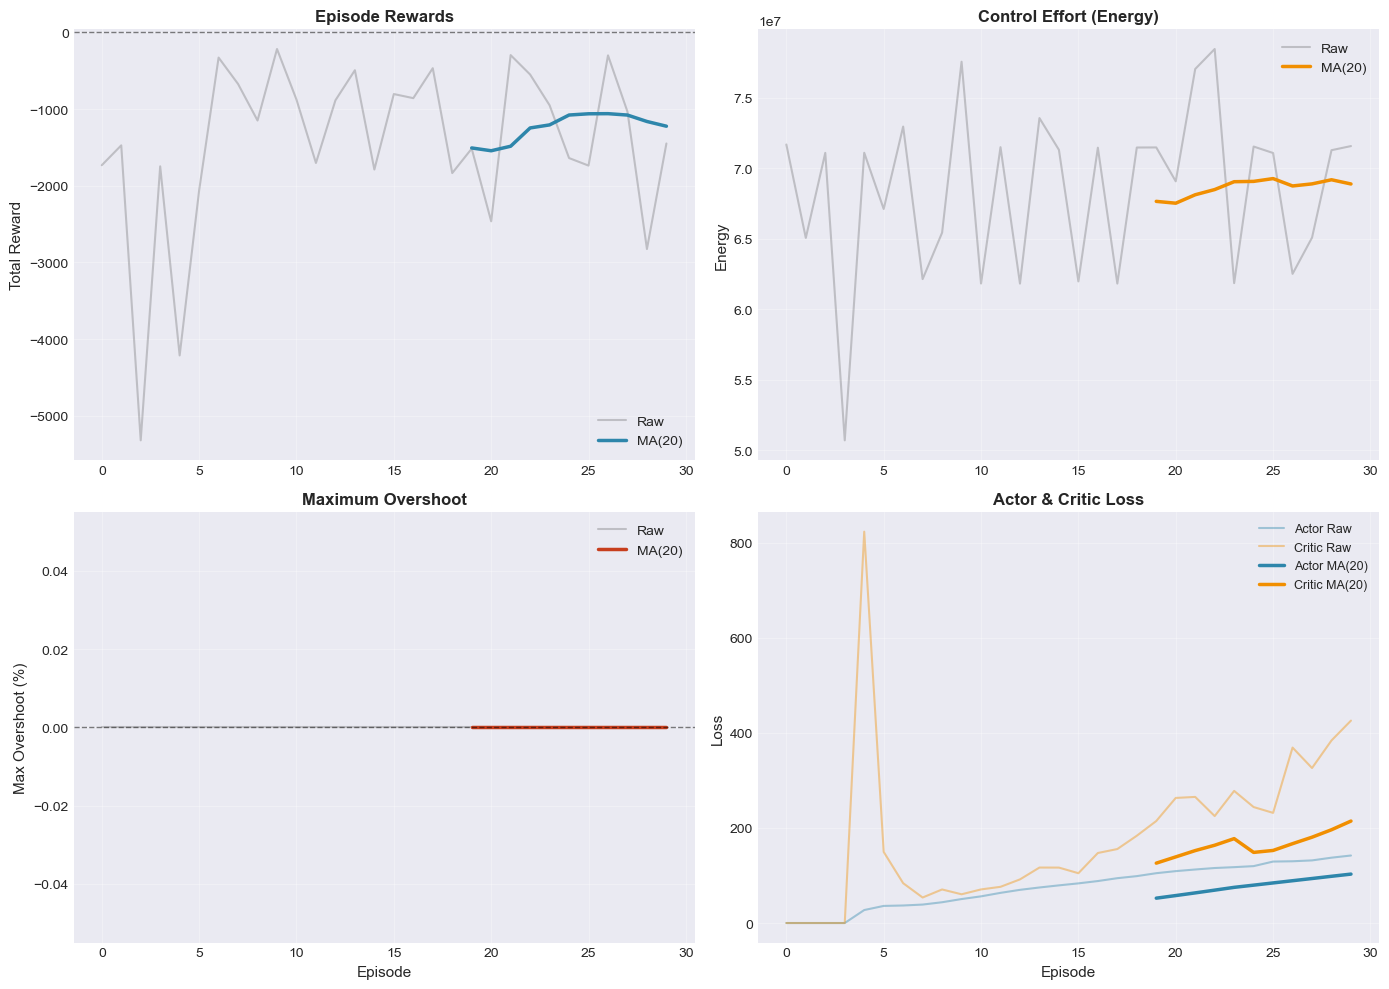

AttributeError: 'DDPGTrainer' object has no attribute 'kp_history'

In [23]:
plotter = SimplePlotter()

# Resumen
print("\n" + "="*70)
print("RESULTADOS CTRL")
print_summary(
    episode_rewards=trainer_ctrl.episode_rewards,
    episode_energies=trainer_ctrl.episode_energies,
    episode_max_overshoots=trainer_ctrl.episode_max_overshoots,
    best_episode_idx=np.argmax(trainer_ctrl.episode_rewards)
)
print("="*70)

# Gráficos
plotter.plot_training_overview(
    episode_rewards=trainer_ctrl.episode_rewards,
    episode_energies=trainer_ctrl.episode_energies,
    episode_max_overshoots=trainer_ctrl.episode_max_overshoots,
    actor=trainer_ctrl.actor_losses,
    critic=trainer_ctrl.critic_losses,
    window=20
)

# Evolución de PIDs
plotter.plot_pid_evolution(
    kp_history=trainer_ctrl.kp_history,
    ki_history=trainer_ctrl.ki_history,
    kd_history=trainer_ctrl.kd_history,
    var_name="CSTR (Tc, F)"
)

## 6. Guardar Checkpoint CTRL

In [18]:
# Guardar modelo CTRL
checkpoint_dir = Path(config_ctrl['checkpoint_dir'])
checkpoint_dir.mkdir(exist_ok=True, parents=True)

ctrl_checkpoint_path = checkpoint_dir / 'agent_ctrl_best.pt'
trainer_ctrl.agent_ctrl.save(str(ctrl_checkpoint_path))

print(f" Agente CTRL guardado en: {ctrl_checkpoint_path}")
print(f"\n Este checkpoint se usará para entrenar ORCH")

DDPG Agent guardado en: checkpoints/cstr_ctrl/agent_ctrl_best.pt
 Agente CTRL guardado en: checkpoints/cstr_ctrl/agent_ctrl_best.pt

 Este checkpoint se usará para entrenar ORCH


---
#  FASE 2: Entrenar Agente ORCH

**Objetivo**: Entrenar un agente orquestador que optimice la concentración Cb del reactor.

**Arquitectura**:
- **ORCH**: Observa Cb, decide setpoints para Tc y F
- **CTRL** (pre-entrenado): Ajusta PIDs para alcanzar esos setpoints
- **CSTR**: Procesa Tc y F → genera Cb

## 7. Configuración ORCH

In [ ]:
ctrl_checkpoint_path = Path('checkpoints/cstr_ctrl/agent_ctrl_best.pt')

In [32]:
config_orch = {
    # ============ AMBIENTE ============
    'env_config': {
        'architecture': 'jerarquica',
        'env_type': 'simulation',
        'max_time_detector': 30,
        'action_type': 'continuous',

        # Variables manipulables (controladas por CTRL)
        'n_manipulable_vars': 2,
        'manipulable_ranges': [
            (290, 450),   # T del reactor [K]
            (99, 105),    # V del reactor [m³]
        ],

        # Variable objetivo (optimizada por ORCH)
        'n_target_vars': 1,
        'target_ranges': [(0.0, 1.0)],           # Cb deseado
        'target_setpoints': [0.4],               # Objetivo: 0.4 mol/m³
        'target_working_ranges': [(0.0, 2.0)],   # Rango físico

        'dt_usuario': 1.0,
        'max_steps': 100,

        'agent_orchestrator_config': {
            'agent_type': 'continuous'
        },

        'env_type_config': {
            'dt': 1.0,
            'control_limits': ((290, 450), (99, 105))
        },

        'reward_weights': {
            'error': 2.0,
            'tiempo': 0.01,
            'overshoot': 0.5,
            'energy': 0.1
        },
        'reward_dead_band': 0.02,

        'pid_limits': [
            (0.01, 50.0),
            (0.001, 5.0),
            (0.001, 5.0)
        ],
        'delta_percent_ctrl': 0.2,
        'delta_percent_orch': 0.1,
    },

    # ============ AGENTE CTRL (Pre-entrenado) ============
    'ctrl_checkpoint_path': str(ctrl_checkpoint_path),  # Usa el checkpoint recién guardado
    'agent_ctrl_config': {
        'algorithm': 'ddpg',
        'state_dim': 10,
        'action_dim': 6,
        'n_vars': 2,
        'action_type': 'continuous',
        'hidden_dims': (128, 64),
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    },

    # ============ AGENTE ORCH (A entrenar) ============
    'agent_orch_config': {
        'state_dim': 5,
        'action_dim': 3,
        'n_vars': 2,
        'hidden_dims': (64, 32),
        'lr_actor': 0.0001,
        'lr_critic': 0.001,
        'entropy_coef': 0.01,
        'warmup_steps': 500,
        'batch_size': 32,
        'target_update_freq': 100,
        'buffer_type': 'simple',
        'buffer_size': 50000,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'seed': 42
    },

    # ============ ENTRENAMIENTO ============
    'n_episodes': 30,
    'max_steps_per_episode': 500,
    'eval_frequency': 50,
    'save_frequency': 9999,
    'log_frequency': 10,
    'checkpoint_dir': 'checkpoints/cstr_orch',
}

print(" Configuración ORCH creada")
print(f"  Checkpoint CTRL: {config_orch['ctrl_checkpoint_path']}")
print(f"  Episodios: {config_orch['n_episodes']}")

 Configuración ORCH creada
  Checkpoint CTRL: checkpoints/cstr_ctrl/agent_ctrl_best.pt
  Episodios: 30


## 8. Test Ambiente Complejo

In [30]:
# Test ambiente
test_env_orch = PIDControlEnv_Complex(config_orch['env_config'])
sim_cfg = config_orch['env_config']['env_type_config']
simulator = CSTRSimulator(**sim_cfg)
test_env_orch.proceso.connect_external_process(simulator)
print(' CSTR conectado al ambiente complejo')

obs, info = test_env_orch.reset()
print(f"\nObservación:")
print(f"  ORCH obs shape: {obs['orch'].shape}")
print(f"  CTRL obs shape: {obs['ctrl'].shape}")
print(f"  Cb actual: {info['target_pvs'][0]:.4f} mol/m³")
print(f"  Cb objetivo: 0.4 mol/m³")

 CSTR conectado al ambiente complejo

Observación:
  ORCH obs shape: (5,)
  CTRL obs shape: (10,)
  Cb actual: 0.6714 mol/m³
  Cb objetivo: 0.4 mol/m³


## 9. Entrenar ORCH

In [33]:
# Crear trainer ORCH
trainer_orch = DDPGTrainer(config_orch)

# Conectar CSTR
sim_cfg = config_orch['env_config']['env_type_config']
simulator = CSTRSimulator(**sim_cfg)
trainer_orch.env.proceso.connect_external_process(simulator)
print(' CSTR conectado al trainer ORCH')

print("\n Entrenando agente ORCH...\n")
trainer_orch.train()
print("\nEntrenamiento ORCH completado")

Cargando agente CTRL pre-entrenado desde: checkpoints/cstr_ctrl/agent_ctrl_best.pt
DDPG Agent creado | role=ctrl | state=10 | action=6 | n_vars=2 | device=cpu
DDPG Agent cargado desde: checkpoints/cstr_ctrl/agent_ctrl_best.pt
DDPG Agent creado | role=orch | state=5 | action=3 | n_vars=2 | device=cpu
 CSTR conectado al trainer ORCH

 Entrenando agente ORCH...


Episodio 0/30
  Reward: -95.95 | Length: 101
  Actor Loss: 0.0000 | Critic Loss: 0.0000
  ORCH Memory: 101

Episodio 10/30
  Reward: -82.51 | Length: 101
  Actor Loss: 1.2954 | Critic Loss: 0.2363
  ORCH Memory: 734

Episodio 20/30
  Reward: -88.87 | Length: 101
  Actor Loss: 3.4980 | Critic Loss: 0.4212
  ORCH Memory: 1646

Entrenamiento ORCH completado


## 10. Visualizar Resultados ORCH

In [ ]:
from Aux.Plots import SimplePlotter, print_summary

plotter = SimplePlotter()


 RESULTADOS ORCH
RESUMEN DE ENTRENAMIENTO

Métrica                        Último       Promedio     Mejor       
Reward                              -82.25      -91.75       -0.65
Energy                                0.00        0.00        0.00
Max Overshoot (%)                     0.00        0.00        0.00

 Mejor episodio: #3 (Reward: -0.65)
Mejora total: 14.3%
Total episodios: 30


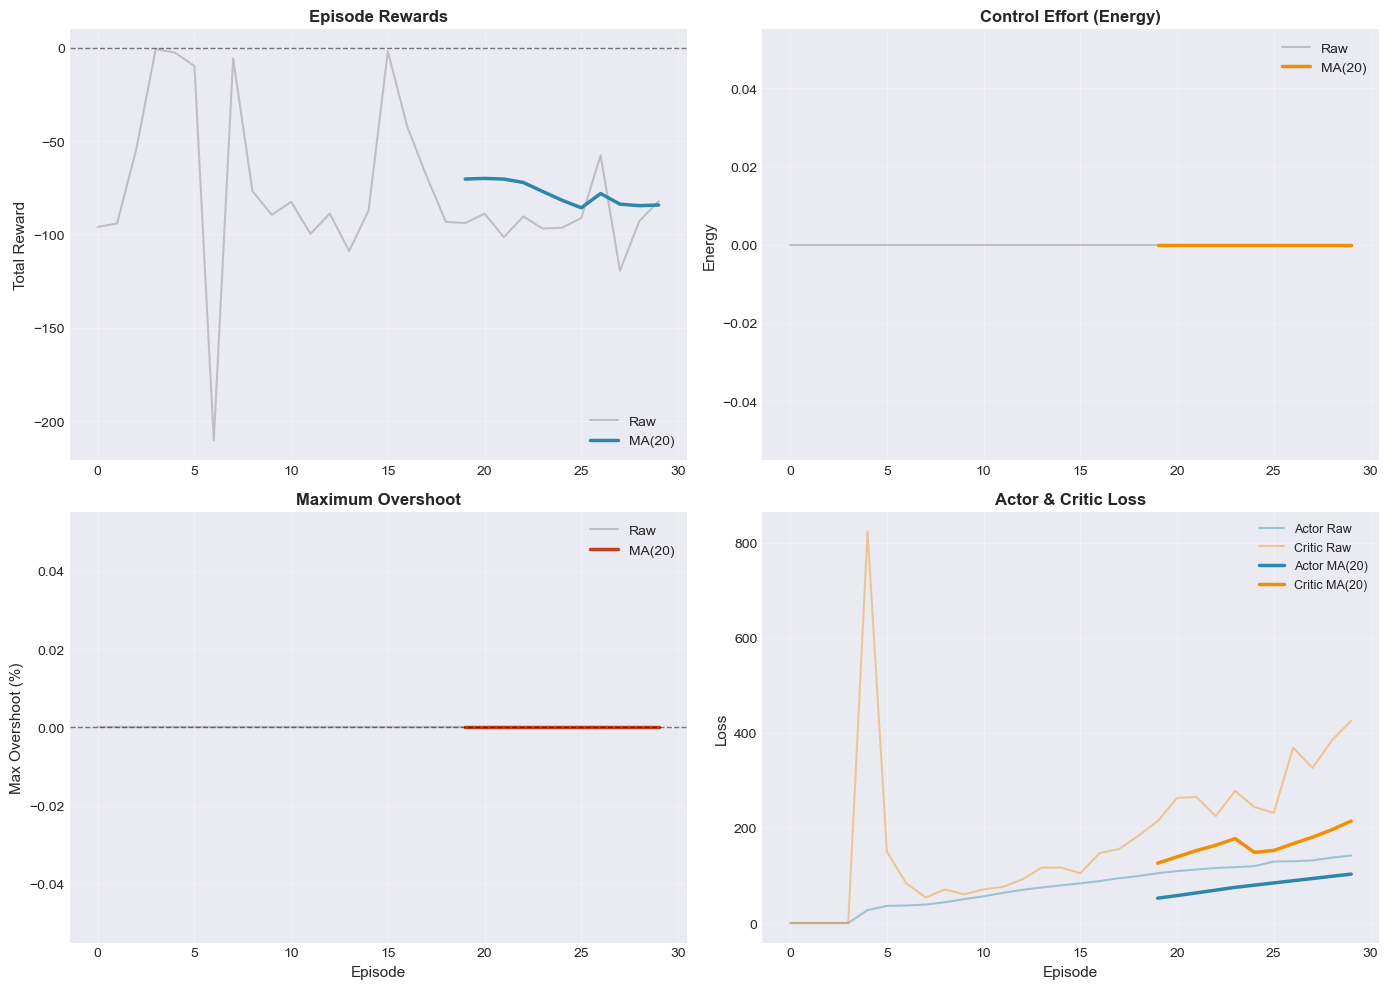

In [35]:
# Resumen
print("\n" + "="*70)
print(" RESULTADOS ORCH")
print_summary(
    episode_rewards=trainer_orch.episode_rewards,
    episode_energies=trainer_orch.episode_energies,
    episode_max_overshoots=trainer_orch.episode_max_overshoots,
    best_episode_idx=np.argmax(trainer_orch.episode_rewards)
)
print("="*70)

# Gráficos
plotter.plot_training_overview(
    episode_rewards=trainer_orch.episode_rewards,
    episode_energies=trainer_orch.episode_energies,
    episode_max_overshoots=trainer_orch.episode_max_overshoots,
    actor=trainer_ctrl.actor_losses,
    critic=trainer_ctrl.critic_losses,
    window=20
)


## 11. Evaluación - Sistema Completo en Acción

In [37]:
# Modo evaluación
trainer_orch.agent_orch.noise.sigma = 0.0

# Reset
obs, info = trainer_orch.env.reset()
print(f" Condiciones iniciales:")
print(f"  Cb: {info['target_pvs'][0]:.4f} mol/m³ (objetivo: 0.4)")
print(f"  Tc: {info['manipulable_pvs'][0]:.2f} K")
print(f"  F: {info['manipulable_pvs'][1]:.2f} m³/s")

# Ejecutar episodio
cb_traj = [info['target_pvs'][0]]
tc_traj = [info['manipulable_pvs'][0]]
f_traj = [info['manipulable_pvs'][1]]
rewards_traj = []

done = False
step = 0
max_steps = 50

print(f"\n Ejecutando episodio...")
print(f"{'Step':<6} {'Cb':<10} {'Tc':<10} {'F':<10} {'Reward':<10}")
print("-" * 50)

while not done and step < max_steps:
    action = trainer_orch.agent_orch.select_action(obs['orch'], training=False)
    obs, reward, terminated, truncated, info = trainer_orch.env.step(action)
    done = terminated or truncated

    cb_traj.append(info['target_pvs'][0])
    tc_traj.append(info['manipulable_pvs'][0])
    f_traj.append(info['manipulable_pvs'][1])
    rewards_traj.append(reward)

    print(f"{step:<6} {info['target_pvs'][0]:<10.4f} {info['manipulable_pvs'][0]:<10.2f} "
          f"{info['manipulable_pvs'][1]:<10.2f} {reward:<10.2f}")

    step += 1

print("-" * 50)
print(f"\n Episodio completado")
print(f"  Cb final: {cb_traj[-1]:.4f} mol/m³")
print(f"  Error final: {abs(cb_traj[-1] - 0.4):.4f}")
print(f"  Reward total: {sum(rewards_traj):.2f}")

 Condiciones iniciales:
  Cb: 1.6707 mol/m³ (objetivo: 0.4)
  Tc: 327.00 K
  F: 102.00 m³/s

 Ejecutando episodio...
Step   Cb         Tc         F          Reward    
--------------------------------------------------


0      0.5812     426.65     99.00      -0.97     
1      0.6992     425.81     99.00      -1.17     
2      0.8157     424.38     99.00      -1.40     
3      0.8133     424.29     99.00      -1.40     
4      0.8133     424.17     99.00      -1.39     
5      0.8133     424.15     99.00      -1.37     
6      0.8133     424.24     99.00      -1.36     
7      0.8133     424.15     99.00      -1.35     
8      0.8133     424.27     99.00      -1.34     
9      0.8133     424.13     99.00      -1.32     
10     0.8133     424.30     99.00      -1.31     
11     0.8133     424.10     99.00      -1.30     
12     0.8133     424.29     99.00      -1.29     
13     0.8133     424.23     99.00      -1.27     
14     0.8133     424.22     99.00      -1.26     
15     0.8133     424.11     99.00      -1.25     
16     0.8133     424.26     99.00      -1.21     
17     0.8133     424.26     99.00      -0.99     
18     0.8133     424.15     99.00      -1.21     
19     0.8133     424.25     99

## 12. Visualización Final

/var/folders/p9/x4lzjw9n02j95nfzjt_b71600000gn/T/ipykernel_82160/981889224.py:39: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/var/folders/p9/x4lzjw9n02j95nfzjt_b71600000gn/T/ipykernel_82160/981889224.py:39: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  plt.tight_layout()
/var/folders/p9/x4lzjw9n02j95nfzjt_b71600000gn/T/ipykernel_82160/981889224.py:39: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BA

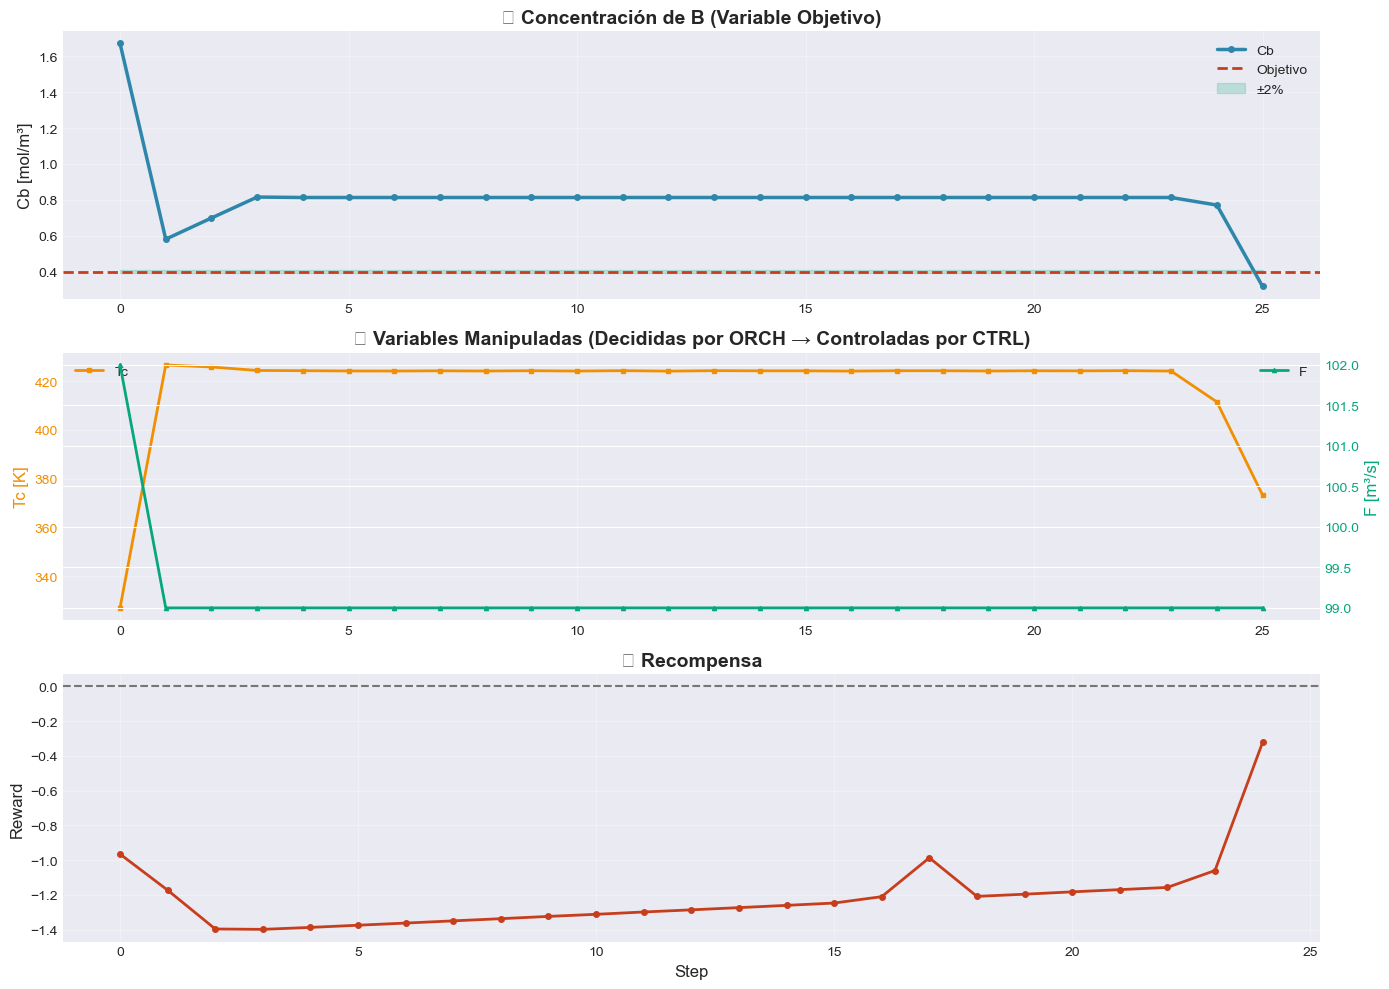

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
steps = np.arange(len(cb_traj))

# Cb
ax = axes[0]
ax.plot(steps, cb_traj, label='Cb', color='#2E86AB', linewidth=2.5, marker='o', markersize=4)
ax.axhline(y=0.4, label='Objetivo', color='#C73E1D', linestyle='--', linewidth=2)
ax.fill_between(steps, 0.392, 0.408, alpha=0.2, color='#06A77D', label='±2%')
ax.set_ylabel('Cb [mol/m³]', fontsize=12)
ax.set_title('🎯 Concentración de B (Variable Objetivo)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Tc y F
ax = axes[1]
ax.plot(steps, tc_traj, label='Tc', color='#F18F01', linewidth=2, marker='s', markersize=3)
ax.set_ylabel('Tc [K]', fontsize=12, color='#F18F01')
ax.tick_params(axis='y', labelcolor='#F18F01')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(steps, f_traj, label='F', color='#06A77D', linewidth=2, marker='^', markersize=3)
ax2.set_ylabel('F [m³/s]', fontsize=12, color='#06A77D')
ax2.tick_params(axis='y', labelcolor='#06A77D')
ax2.legend(loc='upper right')
ax.set_title('🔧 Variables Manipuladas (Decididas por ORCH → Controladas por CTRL)',
             fontsize=14, fontweight='bold')

# Rewards
ax = axes[2]
ax.plot(range(len(rewards_traj)), rewards_traj, color='#C73E1D', linewidth=2, marker='o', markersize=4)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Reward', fontsize=12)
ax.set_title('💰 Recompensa', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Guardar Modelos Finales

In [ ]:
# Guardar ORCH
orch_dir = Path(config_orch['checkpoint_dir'])
orch_dir.mkdir(exist_ok=True, parents=True)
orch_path = orch_dir / 'agent_orch_final.pt'
trainer_orch.agent_orch.save(str(orch_path))

print(f"Modelos guardados:")
print(f"  CTRL: {ctrl_checkpoint_path}")
print(f"  ORCH: {orch_path}")

Agente guardado en: checkpoints/cstr_orch/agent_orch_final.pt
Modelos guardados:
  CTRL: checkpoints/cstr_ctrl/agent_ctrl_best.pt
  ORCH: checkpoints/cstr_orch/agent_orch_final.pt


In [ ]:
# Test: ¿qué Cb produce el CSTR con distintos Tc?
cstr_test = CSTRSimulator()
cstr_test.reset()

for Tc_test in [310, 340, 370, 400, 420, 440]:
    cstr_test.reset()
    for _ in range(500):
        cstr_test.simulate_step_multi([Tc_test, 102.0], 1.0)
    state = cstr_test.get_measurements()
    print(f"Tc={Tc_test}K → Cb={state['Cb']:.4f}")

Tc=310K → Cb=0.2253
Tc=340K → Cb=0.6352
Tc=370K → Cb=0.8673
Tc=400K → Cb=0.8285
Tc=420K → Cb=0.6662
Tc=440K → Cb=0.4422


FASE DE PRUEBA DQN

In [ ]:
config_orch = {
    # ============ AMBIENTE ============
    'env_config': {
        'architecture': 'jerarquica',
        'env_type': 'simulation',
        'max_time_detector': 30,

        # Variables manipulables (controladas por CTRL)
        'n_manipulable_vars': 2,
        'manipulable_ranges': [
            (400, 450),   # T del reactor [K]
            (99, 105),    # V del reactor [m³]
        ],

        # Variable objetivo (optimizada por ORCH)
        'n_target_vars': 1,
        'target_ranges': [(0.0, 1.0)],           # Cb deseado
        'target_setpoints': [0.4],               # Objetivo: 0.4 mol/m³
        'target_working_ranges': [(0.0, 2.0)],   # Rango físico

        'dt_usuario': 1.0,
        'max_steps': 100,

        'agent_orchestrator_config': {
            'agent_type': 'discrete'
        },

        'env_type_config': {
            'dt': 1.0,
            'control_limits': ((400, 450), (99, 105))
        },

        'reward_weights': {
            'error': 2.0,
            'tiempo': 0.01,
            'overshoot': 0.5,
            'energy': 0.1
        },
        'reward_dead_band': 0.02,

        'pid_limits': [
            (0.01, 5.0),
            (0.0, 1.0),
            (0.0, 1.0)
        ],
        'delta_percent_ctrl': 0.2,
        'delta_percent_orch': 0.1,
    },

    # ============ AGENTE CTRL (Pre-entrenado) ============
    'ctrl_checkpoint_path': str(ctrl_checkpoint_path),  # Usa el checkpoint recién guardado
    'agent_ctrl_config': {
        'state_dim': 10,
        'action_dim': 7,
        'n_vars': 2,
        'action_type': 'discrete',
        'hidden_dims': (128, 64),
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    },

    # ============ AGENTE ORCH (A entrenar) ============
    'agent_orch_config': {
        'state_dim': 5,
        'action_dim': 3,
        'n_vars': 2,
        'hidden_dims': (64, 32),
        'lr': 0.001,
        'gamma': 0.99,
        'epsilon_start': 1.0,
        'epsilon_min': 0.05,
        'epsilon_decay': 0.9999,
        'batch_size': 32,
        'target_update_freq': 100,
        'buffer_type': 'simple',
        'buffer_size': 10000,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'seed': 42
    },

    # ============ ENTRENAMIENTO ============
    'n_episodes': 1000,
    'max_steps_per_episode': 500,
    'eval_frequency': 50,
    'save_frequency': 9999,
    'log_frequency': 10,
    'checkpoint_dir': 'checkpoints/cstr_orch',
}

print(" Configuración ORCH creada")
print(f"  Checkpoint CTRL: {config_orch['ctrl_checkpoint_path']}")
print(f"  Episodios: {config_orch['n_episodes']}")

 Configuración ORCH creada
  Checkpoint CTRL: checkpoints/cstr_ctrl/agent_ctrl_best.pt
  Episodios: 1000


In [ ]:
# Crear trainer ORCH
trainer_orch = DQNTrainer(config_orch)

# Conectar CSTR
sim_cfg = config_orch['env_config']['env_type_config']
simulator = CSTRSimulator(**sim_cfg)
trainer_orch.env.proceso.connect_external_process(simulator)
print(' CSTR conectado al trainer ORCH')

print("\n Entrenando agente ORCH...\n")
trainer_orch.train()
print("\nEntrenamiento ORCH completado")

Cargando agente CTRL pre-entrenado desde: checkpoints/cstr_ctrl/agent_ctrl_best.pt
 CSTR conectado al trainer ORCH

 Entrenando agente ORCH...


Episodio 0/1000
  Reward: -70.23
  Length: 101
  CTRL Loss: 0.0000
  CTRL Epsilon: 0.0000
  ORCH Loss: 115.2743
  ORCH Epsilon: 0.9930

Episodio 10/1000
  Reward: -39.71
  Length: 101
  CTRL Loss: 0.0000
  CTRL Epsilon: 0.0000
  ORCH Loss: 24.3614
  ORCH Epsilon: 0.9066

Episodio 20/1000
  Reward: -23.63
  Length: 101
  CTRL Loss: 0.0000
  CTRL Epsilon: 0.0000
  ORCH Loss: 6.2916
  ORCH Epsilon: 0.8441

Episodio 30/1000
  Reward: -30.92
  Length: 101
  CTRL Loss: 0.0000
  CTRL Epsilon: 0.0000
  ORCH Loss: 8.4356
  ORCH Epsilon: 0.7778

Episodio 40/1000
  Reward: -41.96
  Length: 101
  CTRL Loss: 0.0000
  CTRL Epsilon: 0.0000
  ORCH Loss: 6.7837
  ORCH Epsilon: 0.7172

Episodio 50/1000
  Reward: -1.44
  Length: 4
  CTRL Loss: 0.0000
  CTRL Epsilon: 0.0000
  ORCH Loss: 20.8928
  ORCH Epsilon: 0.6546
Evaluación: Reward promedio = -16.88
Agente gu


 RESULTADOS ORCH
RESUMEN DE ENTRENAMIENTO

Métrica                        Último       Promedio     Mejor       
Reward                               -6.94      -56.09       -0.02
Energy                                0.00        0.00        0.00
Max Overshoot (%)                     0.00        0.00        0.00

 Mejor episodio: #624 (Reward: -0.02)
Mejora total: 90.1%
Total episodios: 1000


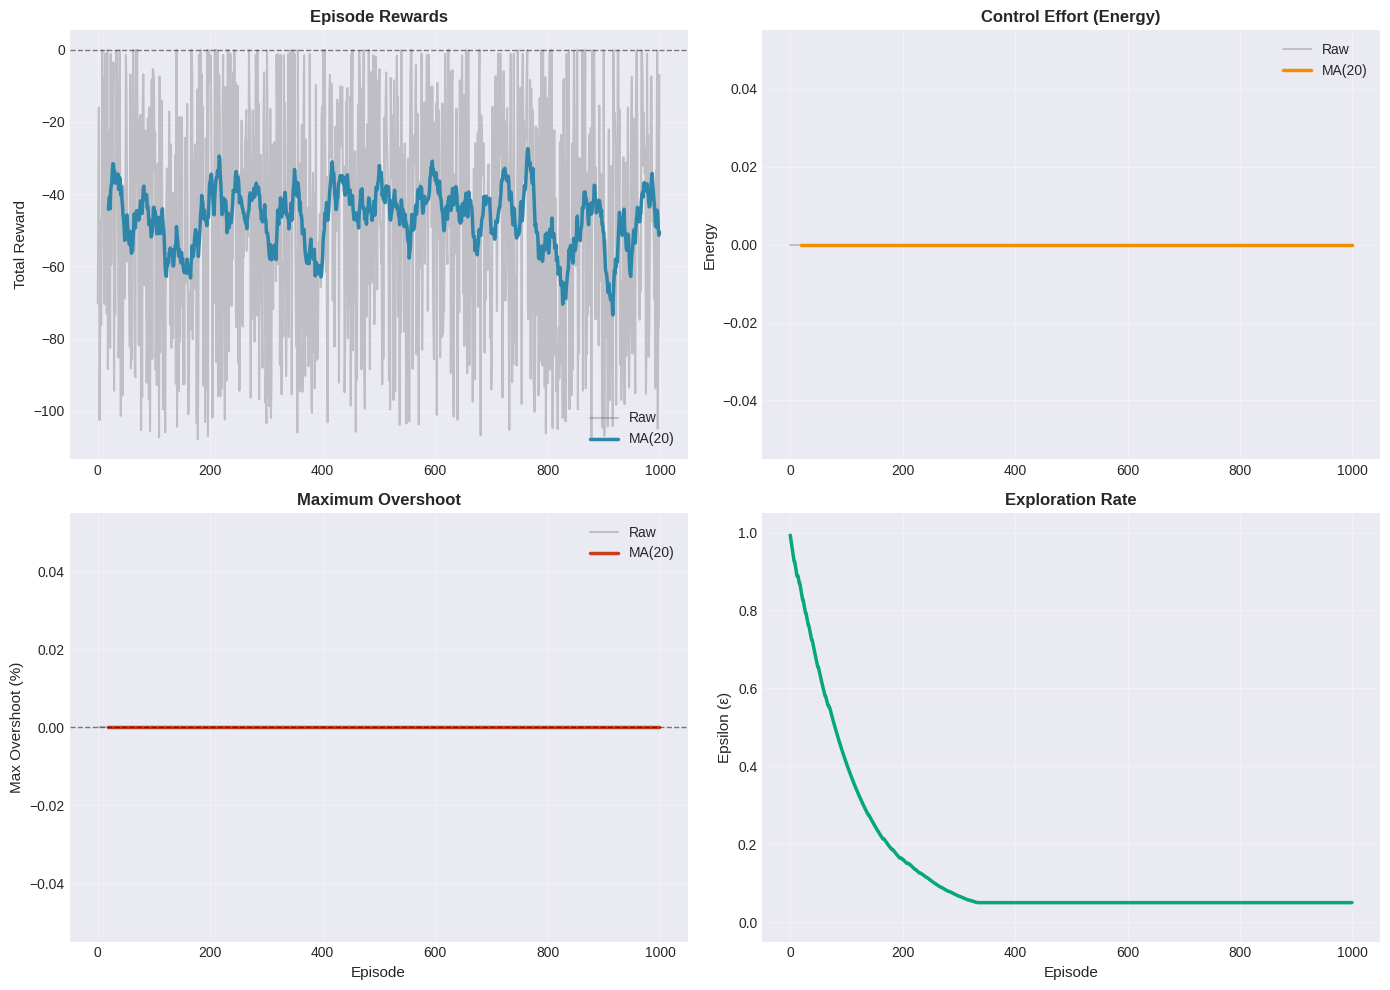

In [ ]:
# Resumen
print("\n" + "="*70)
print(" RESULTADOS ORCH")
print_summary(
    episode_rewards=trainer_orch.episode_rewards,
    episode_energies=trainer_orch.episode_energies,
    episode_max_overshoots=trainer_orch.episode_max_overshoots,
    best_episode_idx=np.argmax(trainer_orch.episode_rewards)
)
print("="*70)

# Gráficos
plotter.plot_training_overview(
    episode_rewards=trainer_orch.episode_rewards,
    episode_energies=trainer_orch.episode_energies,
    episode_max_overshoots=trainer_orch.episode_max_overshoots,
    epsilons=trainer_orch.epsilons,
    window=20
)

In [ ]:
# Modo evaluación
trainer_orch.agent_orch.epsilon = 0.0

# Reset
obs, info = trainer_orch.env.reset()
print(f" Condiciones iniciales:")
print(f"  Cb: {info['target_pvs'][0]:.4f} mol/m³ (objetivo: 0.4)")
print(f"  Tc: {info['manipulable_pvs'][0]:.2f} K")
print(f"  F: {info['manipulable_pvs'][1]:.2f} m³/s")

# Ejecutar episodio
cb_traj = [info['target_pvs'][0]]
tc_traj = [info['manipulable_pvs'][0]]
f_traj = [info['manipulable_pvs'][1]]
rewards_traj = []

done = False
step = 0
max_steps = 50

print(f"\n Ejecutando episodio...")
print(f"{'Step':<6} {'Cb':<10} {'Tc':<10} {'F':<10} {'Reward':<10}")
print("-" * 50)

while not done and step < max_steps:
    action = trainer_orch.agent_orch.select_action(obs['orch'], training=False)
    obs, reward, terminated, truncated, info = trainer_orch.env.step(action)
    done = terminated or truncated

    cb_traj.append(info['target_pvs'][0])
    tc_traj.append(info['manipulable_pvs'][0])
    f_traj.append(info['manipulable_pvs'][1])
    rewards_traj.append(reward)

    print(f"{step:<6} {info['target_pvs'][0]:<10.4f} {info['manipulable_pvs'][0]:<10.2f} "
          f"{info['manipulable_pvs'][1]:<10.2f} {reward:<10.2f}")

    step += 1

print("-" * 50)
print(f"\n Episodio completado")
print(f"  Cb final: {cb_traj[-1]:.4f} mol/m³")
print(f"  Error final: {abs(cb_traj[-1] - 0.4):.4f}")
print(f"  Reward total: {sum(rewards_traj):.2f}")

 Condiciones iniciales:
  Cb: 0.7774 mol/m³ (objetivo: 0.4)
  Tc: 327.00 K
  F: 102.00 m³/s

 Ejecutando episodio...
Step   Cb         Tc         F          Reward    
--------------------------------------------------
0      0.8411     400.00     99.00      -1.38     
1      0.8055     400.00     99.00      -1.31     
2      0.5694     400.00     99.00      -0.84     
3      0.5203     400.00     99.00      -0.74     
4      0.5203     400.00     99.00      -0.74     
5      0.5203     400.00     99.00      -0.74     
6      0.5203     400.00     99.00      -0.74     
7      0.5203     400.00     99.00      -0.74     
8      0.5203     400.00     99.00      -0.74     
9      0.5203     400.00     99.00      -0.74     
10     0.5203     400.00     99.00      -0.74     
11     0.5203     400.00     99.00      -0.74     
12     0.5203     400.00     99.00      -0.74     
13     0.5203     400.00     99.00      -0.74     
14     0.5203     400.00     99.00      -0.74     
15     0.5203   

/tmp/ipython-input-981889224.py:39: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-981889224.py:39: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-981889224.py:39: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Liberation Sans.
  plt.tight_layout()


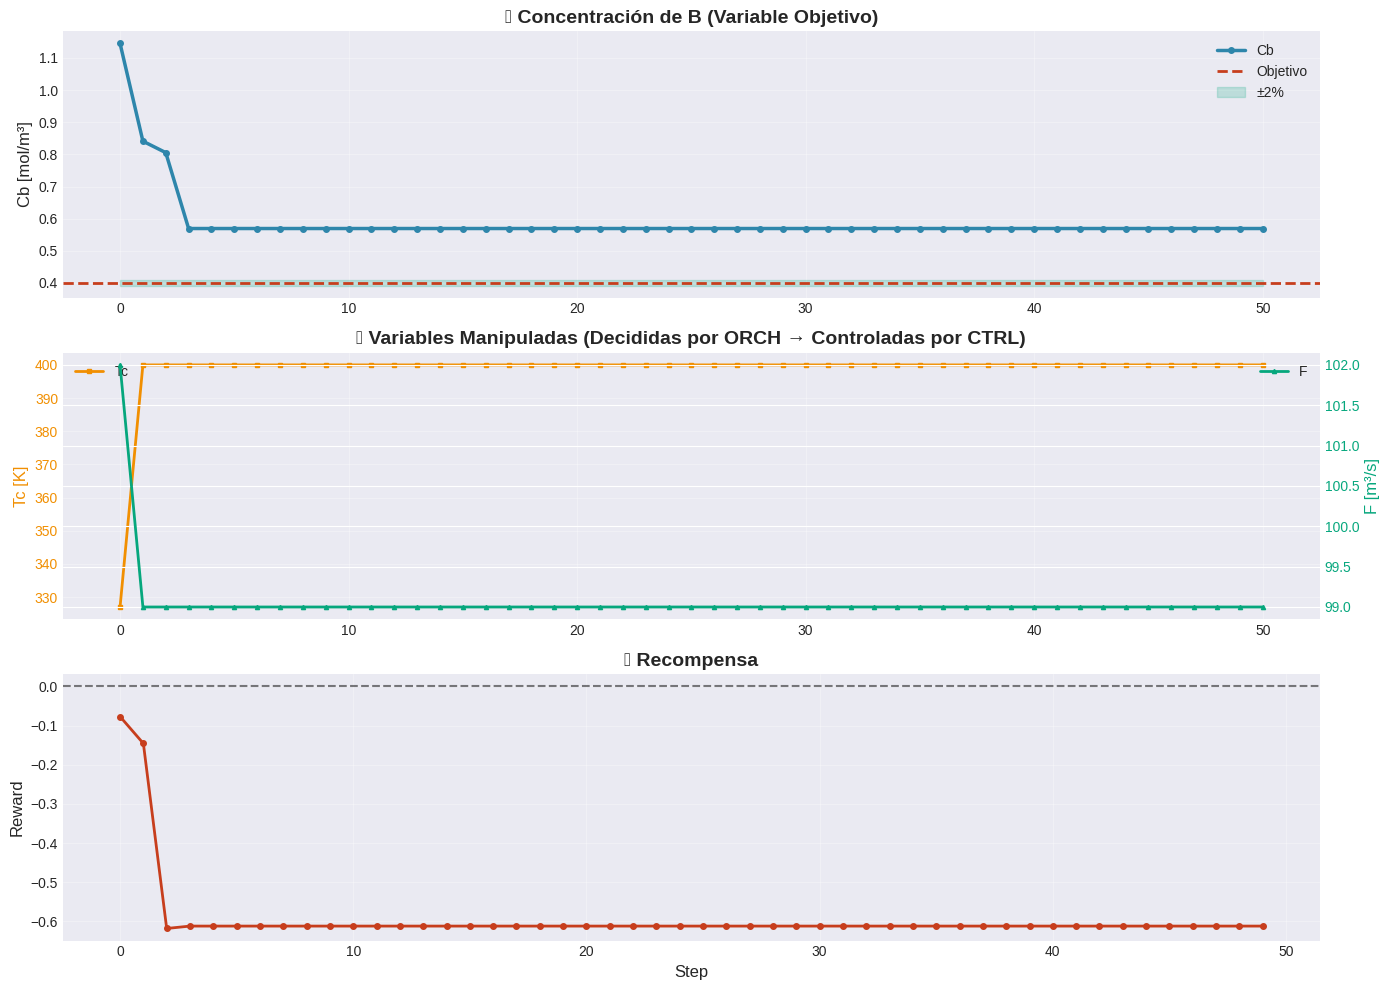

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
steps = np.arange(len(cb_traj))

# Cb
ax = axes[0]
ax.plot(steps, cb_traj, label='Cb', color='#2E86AB', linewidth=2.5, marker='o', markersize=4)
ax.axhline(y=0.4, label='Objetivo', color='#C73E1D', linestyle='--', linewidth=2)
ax.fill_between(steps, 0.392, 0.408, alpha=0.2, color='#06A77D', label='±2%')
ax.set_ylabel('Cb [mol/m³]', fontsize=12)
ax.set_title('🎯 Concentración de B (Variable Objetivo)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Tc y F
ax = axes[1]
ax.plot(steps, tc_traj, label='Tc', color='#F18F01', linewidth=2, marker='s', markersize=3)
ax.set_ylabel('Tc [K]', fontsize=12, color='#F18F01')
ax.tick_params(axis='y', labelcolor='#F18F01')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(steps, f_traj, label='F', color='#06A77D', linewidth=2, marker='^', markersize=3)
ax2.set_ylabel('F [m³/s]', fontsize=12, color='#06A77D')
ax2.tick_params(axis='y', labelcolor='#06A77D')
ax2.legend(loc='upper right')
ax.set_title('🔧 Variables Manipuladas (Decididas por ORCH → Controladas por CTRL)',
             fontsize=14, fontweight='bold')

# Rewards
ax = axes[2]
ax.plot(range(len(rewards_traj)), rewards_traj, color='#C73E1D', linewidth=2, marker='o', markersize=4)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Reward', fontsize=12)
ax.set_title('💰 Recompensa', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ¿Qué reward obtiene el ORCH con distintos Tc fijos?
cstr_test = CSTRSimulator()

for Tc_test in [400, 410, 420, 430, 440, 450]:
    cstr_test.reset()
    for _ in range(500):
        cstr_test.simulate_step_multi([Tc_test, 102.0], 1.0)
    state = cstr_test.get_measurements()
    Cb = state['Cb']
    error = abs(Cb - 0.4)
    reward = -2.0 * error  # peso error=2.0
    print(f"Tc={Tc_test}K → Cb={Cb:.4f} | error={error:.4f} | reward≈{reward:.4f}")

Tc=400K → Cb=0.8275 | error=0.4275 | reward≈-0.8550
Tc=410K → Cb=0.7593 | error=0.3593 | reward≈-0.7185
Tc=420K → Cb=0.6667 | error=0.2667 | reward≈-0.5334
Tc=430K → Cb=0.5564 | error=0.1564 | reward≈-0.3128
Tc=440K → Cb=0.4438 | error=0.0438 | reward≈-0.0876
Tc=450K → Cb=0.3393 | error=0.0607 | reward≈-0.1213


In [ ]:
# ¿Qué acción elige el ORCH entrenado para distintos estados de Cb?
import torch

# Cargar el agente orch entrenado
# Simular distintos estados de observación
for Cb_test in [0.1, 0.3, 0.4, 0.5, 0.7, 0.9]:
    sp = 0.4
    error = sp - Cb_test
    # obs_orch = [pv, sp, error, error_integral, error_derivative]
    obs = np.array([Cb_test, sp, error, 0.0, 0.0], dtype=np.float32)

    action = trainer_orch.agent_orch.select_action(obs, training=False)
    print(f"Cb={Cb_test:.1f} | error={error:+.1f} | acción ORCH → Tc_idx={action[0]}, F_idx={action[1]}")

Cb=0.1 | error=+0.3 | acción ORCH → Tc_idx=1, F_idx=0
Cb=0.3 | error=+0.1 | acción ORCH → Tc_idx=1, F_idx=0
Cb=0.4 | error=+0.0 | acción ORCH → Tc_idx=0, F_idx=1
Cb=0.5 | error=-0.1 | acción ORCH → Tc_idx=0, F_idx=1
Cb=0.7 | error=-0.3 | acción ORCH → Tc_idx=2, F_idx=0
Cb=0.9 | error=-0.5 | acción ORCH → Tc_idx=2, F_idx=0


In [ ]:
# Guardar ORCH
orch_dir = Path(config_orch['checkpoint_dir'])
orch_dir.mkdir(exist_ok=True, parents=True)
orch_path = orch_dir / 'agent_orch_final.pt'
trainer_orch.agent_orch.save(str(orch_path))

print(f"Modelos guardados:")
print(f"  CTRL: {ctrl_checkpoint_path}")
print(f"  ORCH: {orch_path}")

Agente guardado en: checkpoints/cstr_orch/agent_orch_final.pt
Modelos guardados:
  CTRL: checkpoints/cstr_ctrl/agent_ctrl_best.pt
  ORCH: checkpoints/cstr_orch/agent_orch_final.pt
